# Credit Card Fraud

Using [this credit card fraud dataset](https://www.kaggle.com/mlg-ulb/creditcardfraud/kernels) develop an algorithm to predict fraud. Prioritize correctly finding fraud rather than correctly labeling non-fraudulent transactions.

In [165]:
# The basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [166]:
creditcard = pd.read_csv('C:\\Users\\User\\Documents\\Python_scripts\\Thinkful\\creditcard.csv')
creditcard.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Exploring the data

In [167]:
creditcard.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

The datasets contains transactions made by credit cards in September 2013 by European cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

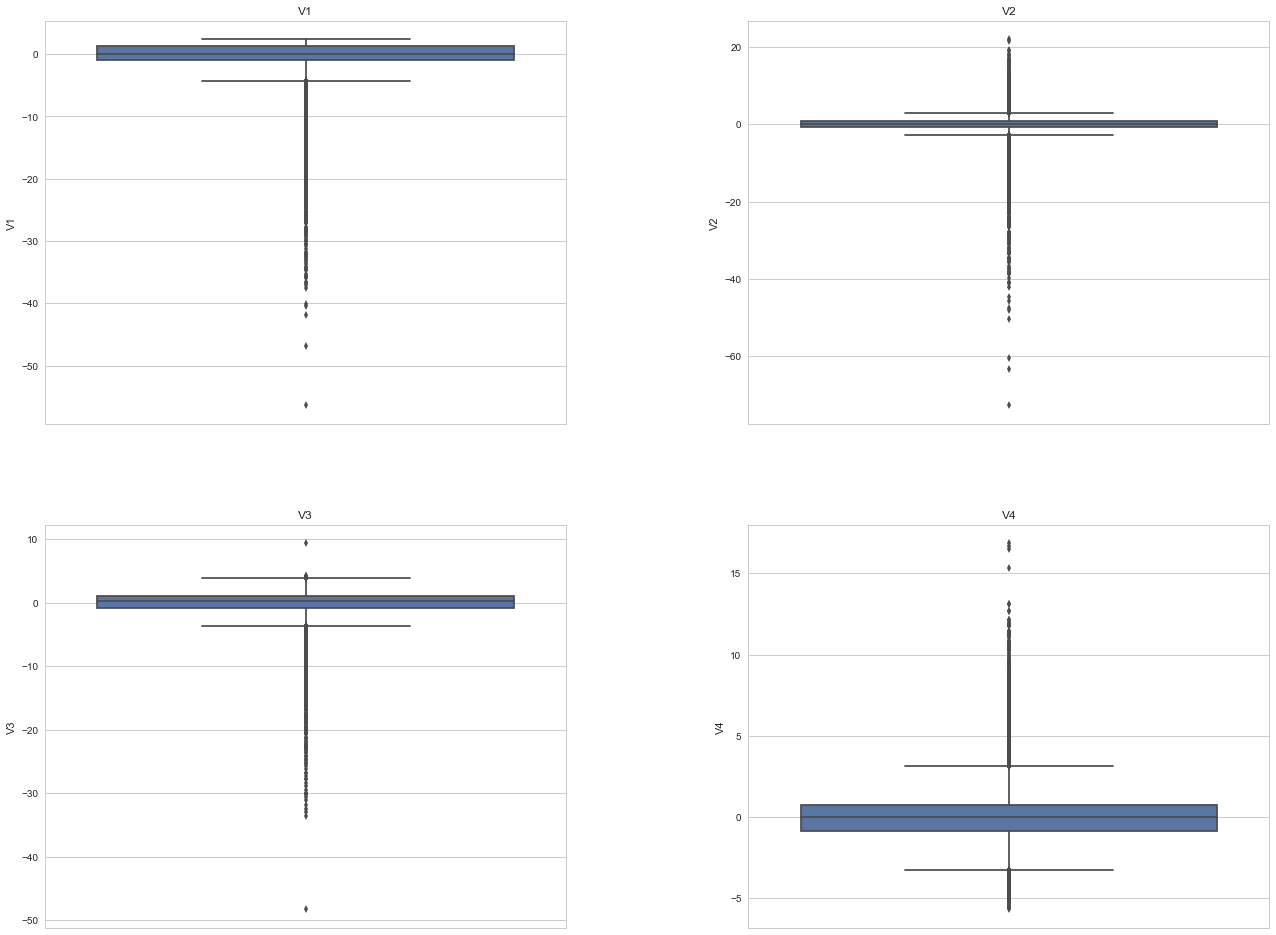

In [23]:
sns.set_style('whitegrid')
plt.figure(figsize=(20,15))
plt.subplot(221)
sns.boxplot(y = 'V1', data=creditcard)
plt.title('V1')
plt.subplot(222)
sns.boxplot(y = 'V2', data=creditcard)
plt.title('V2')
plt.subplot(223)
sns.boxplot(y = 'V3', data=creditcard)
plt.title('V3')
plt.subplot(224)
sns.boxplot(y = 'V4', data=creditcard)
plt.title('V4')
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)
plt.show()

PCA features (V1 - V28) are already centered and standardized (because the principle components have to be centered and standardized before the transformation occurs).

Amount and Time are the only two components with different means and standard deviations. 

Features are centered, but contain several outliers.

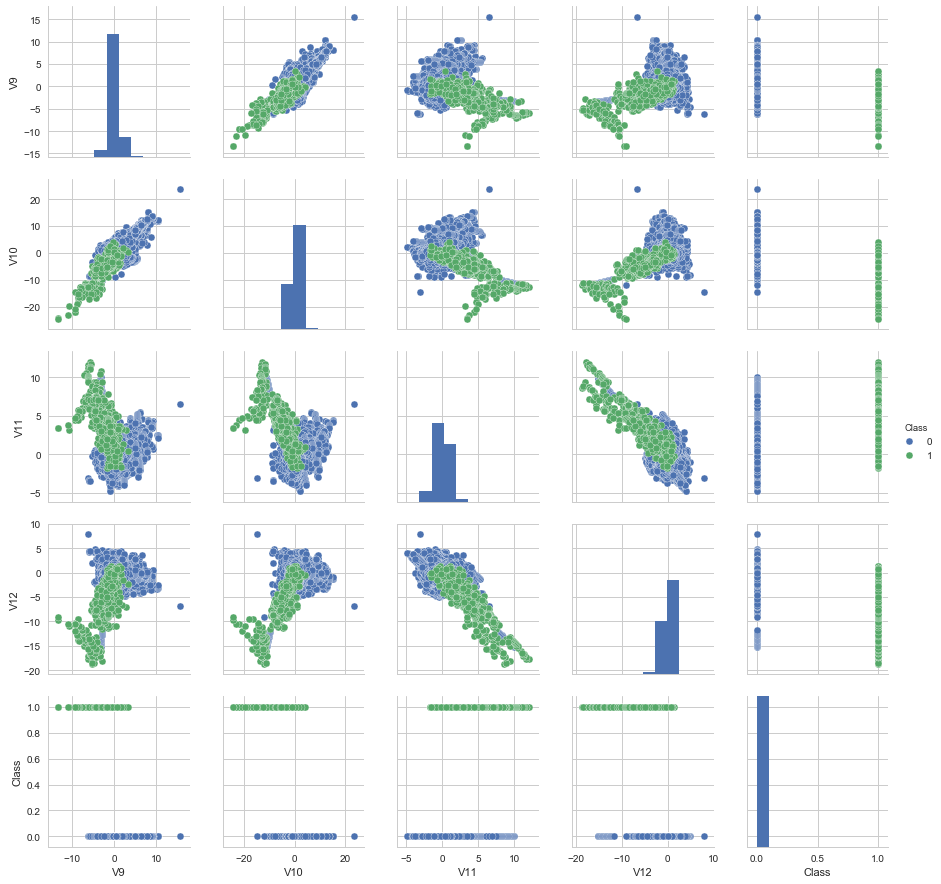

In [30]:
sns.pairplot(creditcard[["V9", "V10", "V11", "V12", "Class"]], hue="Class", diag_kind="hist")
plt.show()

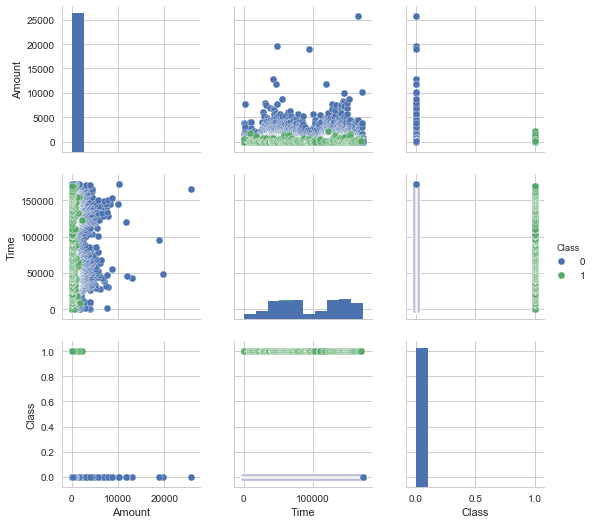

In [36]:
sns.pairplot(creditcard[["Amount", "Time", "Class"]], hue="Class", diag_kind="hist")
plt.show()

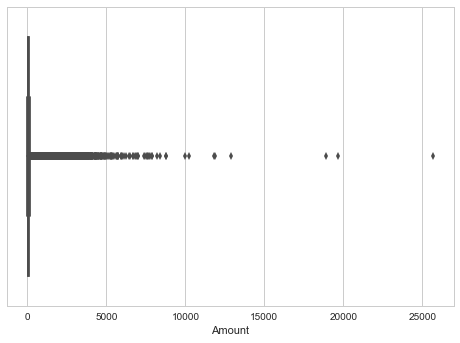

In [60]:
sns.boxplot(creditcard.Amount)

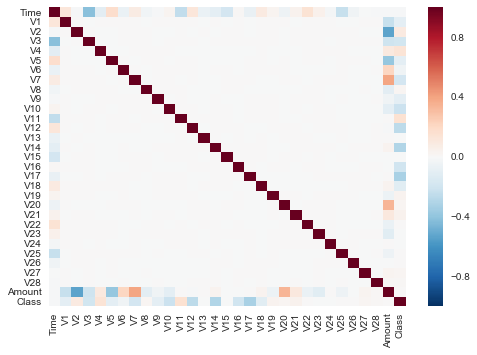

In [37]:
# Checking correlations
corrs = creditcard.corr()
sns.heatmap(corrs)

In [168]:
from sklearn import preprocessing
from sklearn import model_selection

# Scale using RobustScale to account for outliers in Amount
scaler = preprocessing.RobustScaler()
norm = scaler.fit_transform(creditcard.loc[:,['Amount', 'Time']])
norm = pd.DataFrame(norm, columns=['Amount', 'Time'])

# Get data into the right shape, drop Amount, Time, Class
credit = creditcard.loc[:, ~((creditcard.columns).isin(['Amount', 'Time', 'Class']))]

# Add transformed Amount and Time for final features (X) and create outcome (Y)
X = pd.concat([credit, norm], axis=1)
y = creditcard['Class']

# Split on X and y, stratifying on y
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, stratify=y)

# Making the X_train set balanced w.r.t y

# First join X_train and y_train again
Xwithy = X_train.copy()
Xwithy['y']=y.Class
# Then randomly select as many features with y=0 as there are where y=1
countoffrauds = Xwithy.loc[Xwithy['y']==1, 'Xwithy'].sum()
notfrauds = Xwithy.loc[Xwithy['y']==0, :].sample(countoffrauds, replace=False)
# Get a dataset of only y=1
fraud = Xwithy.loc[Xwithy['y']==1,:]
# Join the two datasets
balanced = pd.concat(notfrauds, fraud)
#Split out X and y again
X_balanced = balanced.drop('y', axis=1)
y_balanced = balanced['y']

## First attempt: Logistic Regression with Ridge
Logistic regression is a good baseline model. The heatmap shows that multicollinearity is low among features and the scatter plots show some (log) linearity.

In [169]:
from sklearn import linear_model

# Running logit with Ridge penalty
logit = linear_model.LogisticRegression()
logit.fit(X_train, y_train)

# Getting predicted y from test
y_hat = logit.predict_proba(X_test)[:,1]

# Assume threshold of .5
threshold = np.where(y_hat>0.5,1,0)
cross = pd.crosstab(threshold, y_test)
print(cross)
acc = (cross[0][0]+cross[1][1])/len(y_hat)
sensitive = cross[1][1]/(cross[1][0]+cross[1][1])
print('Accuracy is: ', acc)
print('Sensitivity is: ', sensitive)

Class      0   1
row_0           
0      71064  46
1         15  77
Accuracy is:  0.999143282492
Sensitivity is:  0.626016260163


For credit card fraud monitoring I assume that the most important consideration is maximizing correctly predicted fraud (y = 1 and predicted y =1), while minimizing the number of fraudulent transactions which are classified as non-fraudulent (y=1 and predicted y = 0) as this carries high risk. While misclassifying normal transaction as fraudulent also carries some penalty (e.g. resources to investigate possible fraud and possible customer unhappiness if a card is wrongly blocked) it is arguably carries less financial (and reputational) risk than missing fraudulent transactions.

Hence, the model should optimize on sensitivity (TP/(FN+TP)).

In [174]:
y_test.value_counts()

0    71079
1      123
Name: Class, dtype: int64

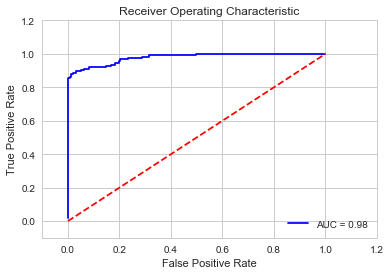

In [175]:
# Optimising threshold - focus is on predicting fraud

from sklearn import metrics

preds = logit.predict_proba(X_test)[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [176]:
# Assume threshold of .1
threshold = np.where(y_hat>0.1,1,0)
cross = pd.crosstab(threshold, y_test)
print(cross)

# Change to df to make life easy
table_pd = pd.DataFrame(cross)

acc = (cross[0][0]+cross[1][1])/len(y_hat)

test_tI_errors = table_pd.iloc[0,1]/(table_pd.iloc[0,0]+table_pd.iloc[1,1]+
                                               table_pd.iloc[1,0]+table_pd.iloc[0,1])
test_tII_errors = table_pd.iloc[1,0]/(table_pd.iloc[0,0]+table_pd.iloc[1,1]+
                                               table_pd.iloc[1,0]+table_pd.iloc[0,1])
sensitive = table_pd.iloc[1,1]/(table_pd.iloc[1,1]+table_pd.iloc[0,1])
print((
    'Test set accuracy: {}\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n'
    'Test set sensitivity: {}').format(acc, test_tI_errors, test_tII_errors, sensitive))

Class      0   1
row_0           
0      71048  25
1         31  98
Test set accuracy: 0.9992135052386169
Percent Type I errors: 0.0003511137327603157
Percent Type II errors: 0.0004353810286227915
Test set sensitivity: 0.7967479674796748


So by setting a low threshold the sensitivity of the model (TP/(FN + TP)) is improved (from 0.63).  However this comes at a cost of nearly tripling the amount of false positives - which can lead to extra work for the fraud detection unit (more cases to assess) and may lead to client unhappiness (e.g. if a credit card is blocked when no fraud is present).

The low threshold is interesting. Given the large inbalance in the dataset (towards Class 0) we are basically interpreting *any* positive probability of fraud (for a particular Xi) as a fraud case.

In [177]:
# Cross validating to make sure the model is not overfitting
score = 'recall'
logit = linear_model.LogisticRegression()
sensitivity_cv = model_selection.cross_val_score(logit, X, y, cv = 5, scoring=score)

In [178]:
print(sensitivity_cv)

[ 0.78787879  0.63636364  0.43877551  0.67346939  0.47959184]


While this model gives a good baseline, the CV shows that it is overfitting and therefore is not a particularly useful model. With 30 features, there is a lot of scope for the violation of assumptions, and arguably no need to impose a (log) linear model.

In [ ]:
# DON"T RUN YET, NOT COMPLETE

# One last roll of the dice: Using the balanced dataset

# This time using CV at the start and applying the best model

balanced_split = model_selection.Kfold(n_splits = 5, shuffle=True)

df = pd.Dataframe()
sensitivity = []
for train_index, test_index in balanced_split.split(X_balanced, y_balanced):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    logit_balanced = linear_model.LogisticRegression()
    logit_balanced.fit(X_train, y_train)
    pd.concat(df, logit_balanced.predict_proba(X_test))
    # Calculate sensitivity of each model
    # Or use average of model?

## Random forests

Class      0   1
row_0           
0      71073  26
1          6  97
Accuracy is:  0.999550574422
Sensitivity is:  0.788617886179


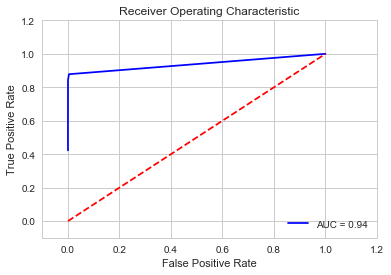

In [179]:
from sklearn import ensemble

# Initialising and fitting the model
rf = ensemble.RandomForestClassifier()
rf.fit(X_train, y_train)

# Testing prediction
y_hat = rf.predict_proba(X_test)[:,1]

# Assume threshold of .5
threshold = np.where(y_hat>0.5,1,0)
cross = pd.crosstab(threshold, y_test)
print(cross)
acc = (cross[0][0]+cross[1][1])/len(y_hat)
sensitive = cross[1][1]/(cross[1][0]+cross[1][1])
print('Accuracy is: ', acc)
print('Sensitivity is: ', sensitive)

preds = rf.predict_proba(X_test)[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [180]:
# Assume threshold of .2
threshold = np.where(y_hat>0.2,1,0)
cross = pd.crosstab(threshold, y_test)
print(cross)

# Change to df to make life easy
table_pd = pd.DataFrame(cross)

acc = (cross[0][0]+cross[1][1])/len(y_hat)

test_tI_errors = table_pd.iloc[0,1]/(table_pd.iloc[0,0]+table_pd.iloc[1,1]+
                                               table_pd.iloc[1,0]+table_pd.iloc[0,1])
test_tII_errors = table_pd.iloc[1,0]/(table_pd.iloc[0,0]+table_pd.iloc[1,1]+
                                               table_pd.iloc[1,0]+table_pd.iloc[0,1])
sensitive = table_pd.iloc[1,1]/(table_pd.iloc[1,1]+table_pd.iloc[0,1])
print((
    'Test set accuracy: {}\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n'
    'Test set sensitivity: {}').format(acc, test_tI_errors, test_tII_errors, sensitive))

Class      0    1
row_0            
0      71063   20
1         16  103
Test set accuracy: 0.9994943962248252
Percent Type I errors: 0.0002808909862082526
Percent Type II errors: 0.00022471278896660205
Test set sensitivity: 0.8373983739837398


This is a good improvement in precision from the logit model, with the lower Type II errors.

However, random forests can suffer from high variance (if they are not pruned) which makes their results fragile to the specific training data used.

In [181]:
# Cross validating to make sure the model is not overfitting
score = 'recall'
rfc = ensemble.RandomForestClassifier()
recall_cv = model_selection.cross_val_score(rfc, X, y, cv = 5, scoring=score)
print(recall_cv)

[ 0.97979798  0.74747475  0.65306122  0.79591837  0.64285714]


So unfortunately the model is still overfitting.

One way to address the imbalance of the data is by using weighted random forest (as suggested [here](https://statistics.berkeley.edu/sites/default/files/tech-reports/666.pdf)).

"Since the RF classifier tends to be biased towards the majority class, we
shall place a heavier penalty on misclassifying the minority class. We assign a weight to each class, with the
minority class given larger weight (i.e., higher misclassification cost). The class weights are incorporated
into the RF algorithm in two places. In the tree induction procedure, class weights are used to weight
the Gini criterion for finding splits. In the terminal nodes of each tree, class weights are again taken into
consideration. The class prediction of each terminal node is determined by “weighted majority vote”; i.e.,
the weighted vote of a class is the weight for that class times the number of cases for that class at the
terminal node. The final class prediction for RF is then determined by aggregatting the weighted vote from
each individual tree, where the weights are average weights in the terminal nodes. Class weights are an
essential tuning parameter to achieve desired performance. The out-of-bag estimate of the accuracy from
RF can be used to select weights."

In [182]:
# CV with class weights
rfc = ensemble.RandomForestClassifier(class_weight='balanced')
precision_cv = model_selection.cross_val_score(rfc, X, y, cv = 5, scoring=score)
print(precision_cv)

[ 0.80808081  0.76767677  0.64285714  0.64285714  0.16326531]


In [186]:
# Trying to build a more robust random forest

# Gridsearch to find optimal values of some of the hyperparameters in boosting model
# Adjusting n_estimators to build more complex trees
# Not adjusting max_features - auto works best
# Adjusting min_sample_split to prevent overfitting (could also try max_depth or min_sample_leaf)

params = { "n_estimators" : [5,10,50],
         'min_samples_split': [2,10]}

# Initialize the model
rf = ensemble.RandomForestClassifier()

# Apply GridSearch to the model
grid = model_selection.GridSearchCV(rf, params)

#Fit on train datase
grid.fit(X_train, y_train)
y_pred = grid.predict(X_test)
y_pred_probs = grid.predict_proba(X_test)
table_pd = pd.DataFrame(pd.crosstab(y_pred, y_test, margins=True))
print(table_pd)

grid.best_estimator_

Class      0    1    All
row_0                   
0      71073   22  71095
1          6  101    107
All    71079  123  71202


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

## Gradient boosting

In [ ]:
# Gridsearch to find optimal values of some of the hyperparameters in boosting model
params = {'n_estimators': [10, 100, 500],
          'max_depth': [2, 4]}
# Initialize the model
gbc = ensemble.GradientBoostingClassifier()
grid = model_selection.GridSearchCV(gbc, params)

#Fit on train datase
grid.fit(X_train, y_train)
y_pred = grid.predict(X_test)
table_pd = pd.DataFrame(pd.crosstab(y_test, y_pred, margins=True))
print(table_pd)

grid.best_estimator_

In [ ]:
# Cross validating
score = 'recall'
gbc = ensemble.GradientBoostingClassifier(n_estimators = XXX, max_depth = XXX)
recall_cv = model_selection.cross_val_score(gbc, X, y, cv = 5, scoring=score)
print(recall_cv)

